In [1]:
import torch
import os, sys
import numpy as np
module_rootdir = '../../..'
dataset_rootdir = '../../../..'
label_rootdir = module_rootdir
weight_rootdir = module_rootdir
sys.path.append(module_rootdir)

from modules.first_stage.inference import inference
from modules.first_stage.set_parameters_for_inference import set_param_for_inference
from modules.plot.viz_annotation import vizualize_bbox_resized

In [2]:
weights_file = 'model_weights/1705990924432/anchor_free_detector.pt'

param_dict = set_param_for_inference(
    dataset_type = 'bdd',
    module_rootdir = module_rootdir,
    dataset_rootdir = dataset_rootdir,
    label_rootdir = label_rootdir,
    batch_size = 1,
    trained_weights_file = os.path.join(weight_rootdir, weights_file))

device = param_dict['device']
dataset_param = param_dict['dataset_param']
dataset_train = param_dict['dataset_train']
dataset_val = param_dict['dataset_val'] 
detector = param_dict['detector']

deltas_mean = torch.tensor(dataset_param.deltas_mean, dtype=torch.float32, device=device)
deltas_std = torch.tensor(dataset_param.deltas_std, dtype=torch.float32, device=device)
grid_coord = dataset_param.grid_coord.to(device)

GPU is available. Good to go!
printing model config parameters
----------------------------------------------------------------------------------------------------
backbone                        : efficientnet_b4
num_backbone_nodes              : 4
num_extra_blocks                : 1
num_levels                      : 5
extra_blocks_feat_dim           : 512
num_fpn_blocks                  : 2
fpn_feat_dim                    : 128
prediction head stem_channels   : [128, 128, 128, 128]
activation                      : swish
image dimension BDD (H, W, D)   : (360, 640, 3)
image dimension KITTI (H, W, D) : (263, 873, 3)
num_classes                     : 2
DEVICE                          : cuda
****************************************************************************************************
 
Load JSON file .. please wait
annotations from 69863/69863 aggregated : Aggregation COMPLETE
Load JSON file .. please wait
annotations from 10000/10000 aggregated : Aggregation COMPLETE


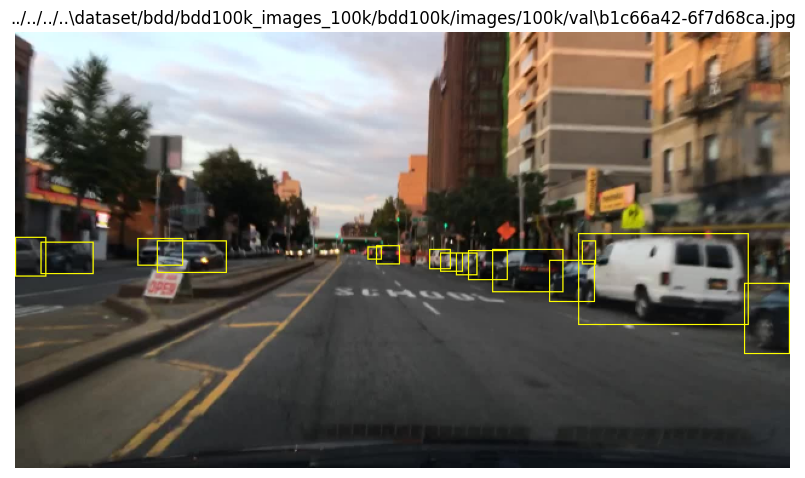

prediction scores in ascending order:
[0.6035659  0.77519244 0.7773149  0.8242005  0.8362695  0.8407127
 0.84763306 0.8711515  0.88296014 0.9040719  0.90811515 0.9102956
 0.9233598  0.9318566  0.9390647 ]
classification scores in ascending order:
[0.9060327  0.997995   0.9984414  0.9986052  0.99913955 0.9993855
 0.9994825  0.99949217 0.9994936  0.99956137 0.99956745 0.9995974
 0.9995974  0.99962354 0.9997309 ]


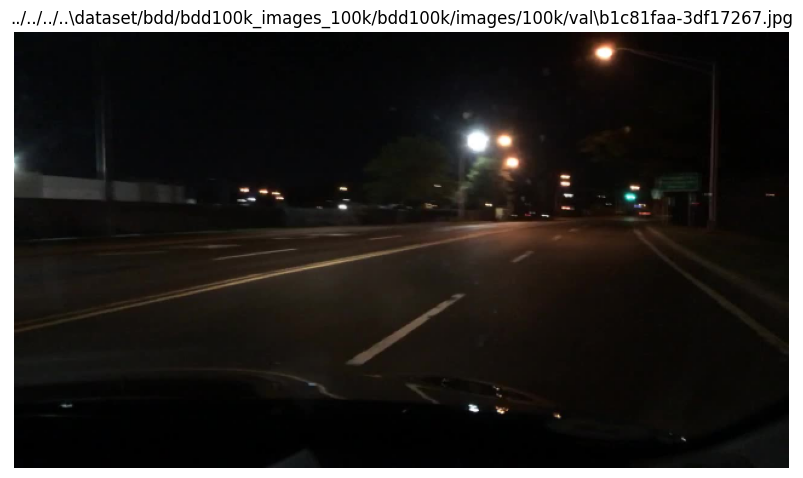

prediction scores in ascending order:
[]
classification scores in ascending order:
[]


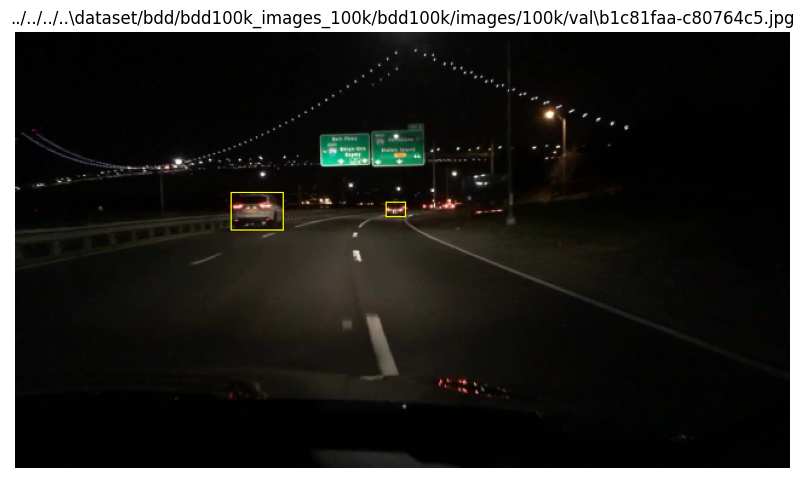

prediction scores in ascending order:
[0.87602985 0.893006  ]
classification scores in ascending order:
[0.99950325 0.99964356]


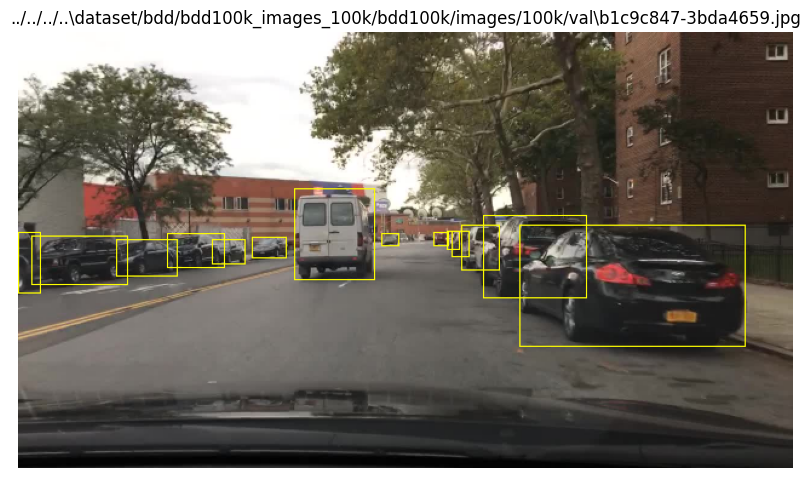

prediction scores in ascending order:
[0.67669326 0.68979937 0.6973926  0.78985023 0.8074556  0.8550665
 0.8666628  0.8786353  0.8987258  0.90215635 0.90938365 0.92859125
 0.9422309  0.961183  ]
classification scores in ascending order:
[0.9987362  0.99901783 0.99908495 0.9991903  0.99928325 0.9995271
 0.99955124 0.9995684  0.99957913 0.9996897  0.99969685 0.9998604
 0.999871   0.9999306 ]


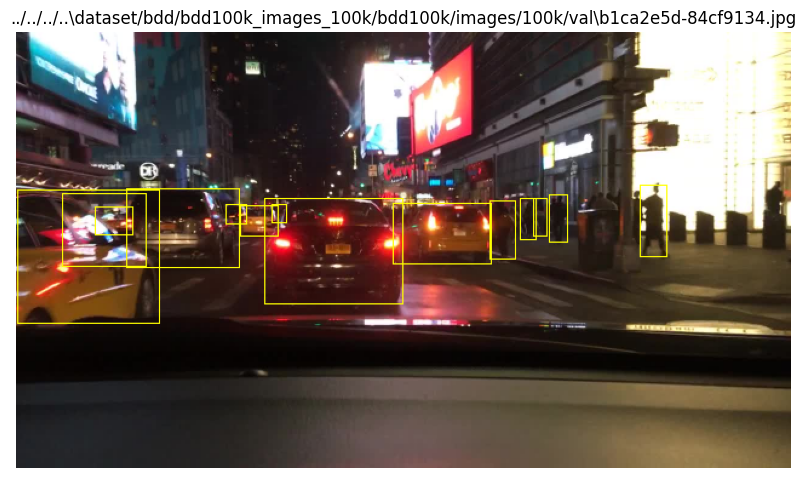

prediction scores in ascending order:
[0.6049419  0.6208395  0.634699   0.65872145 0.7184208  0.79266673
 0.7957776  0.8059278  0.811223   0.89178133 0.92432576 0.92579705
 0.93288445 0.93734276]
classification scores in ascending order:
[0.9852814  0.98959315 0.99059033 0.99406743 0.99492174 0.99727124
 0.99768555 0.9978284  0.9980483  0.99887246 0.9989973  0.9990414
 0.99930644 0.9995214 ]


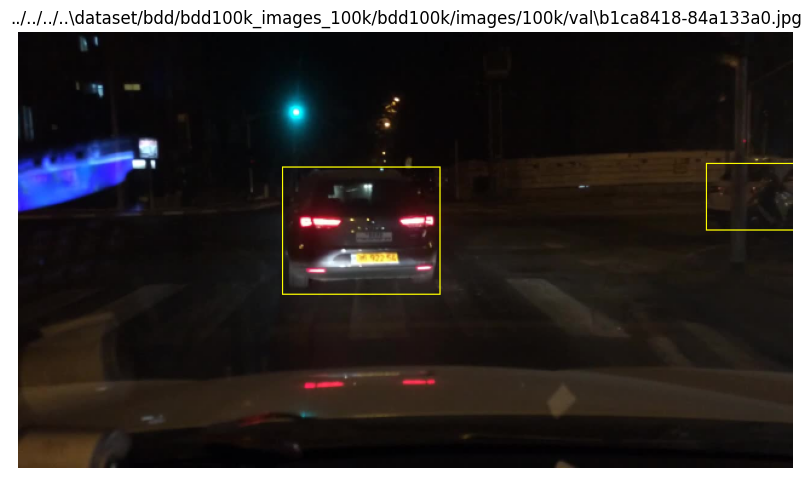

prediction scores in ascending order:
[0.7679271 0.9168579]
classification scores in ascending order:
[0.9685732 0.9993999]


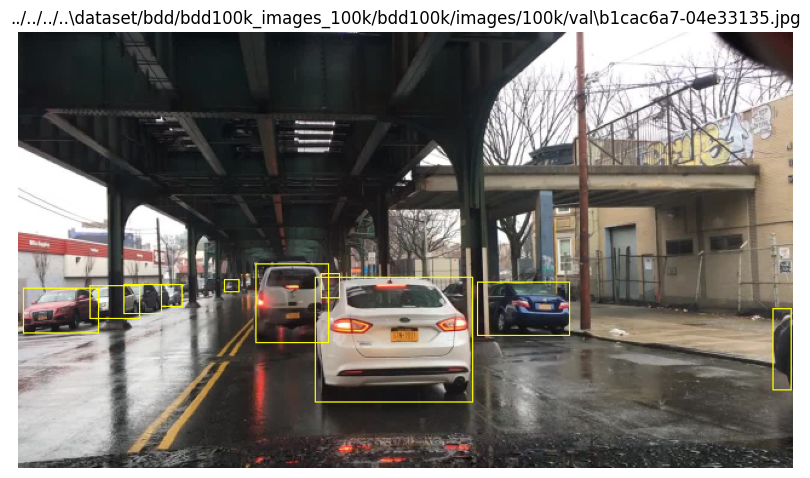

prediction scores in ascending order:
[0.6457341  0.75254947 0.7671692  0.79827416 0.8303714  0.8859073
 0.9255793  0.93279344 0.9331554  0.9360005 ]
classification scores in ascending order:
[0.9927026  0.99576366 0.9982412  0.9991352  0.9994759  0.9995202
 0.9996014  0.99960595 0.99962115 0.9998567 ]


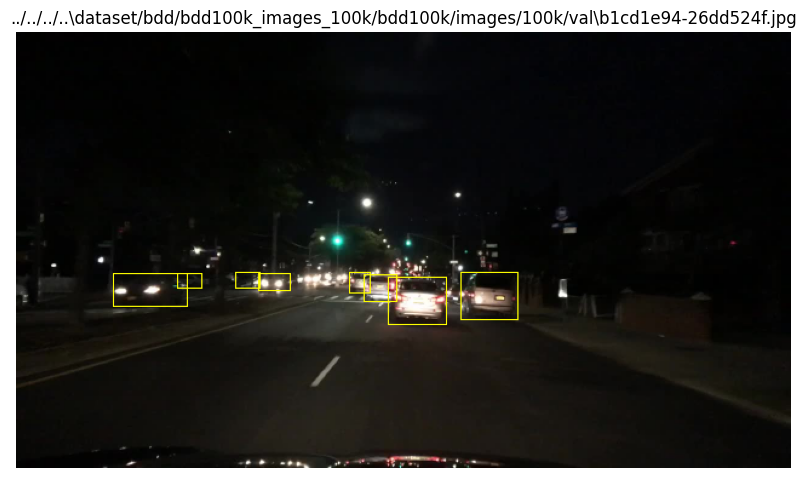

prediction scores in ascending order:
[0.60974413 0.66323334 0.7963376  0.84239674 0.86585397 0.908575
 0.9187896  0.9336697 ]
classification scores in ascending order:
[0.9995384  0.99954224 0.99955446 0.9995714  0.9995772  0.999653
 0.9996747  0.999826  ]


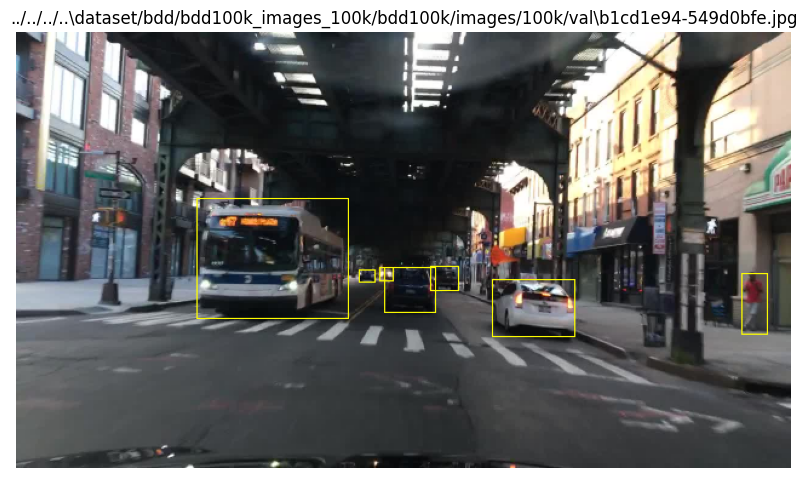

prediction scores in ascending order:
[0.66604114 0.86060786 0.86200124 0.86288524 0.92880005 0.92884284
 0.9340701 ]
classification scores in ascending order:
[0.9896157  0.9970151  0.99855417 0.99919873 0.9993338  0.9995347
 0.9995389 ]


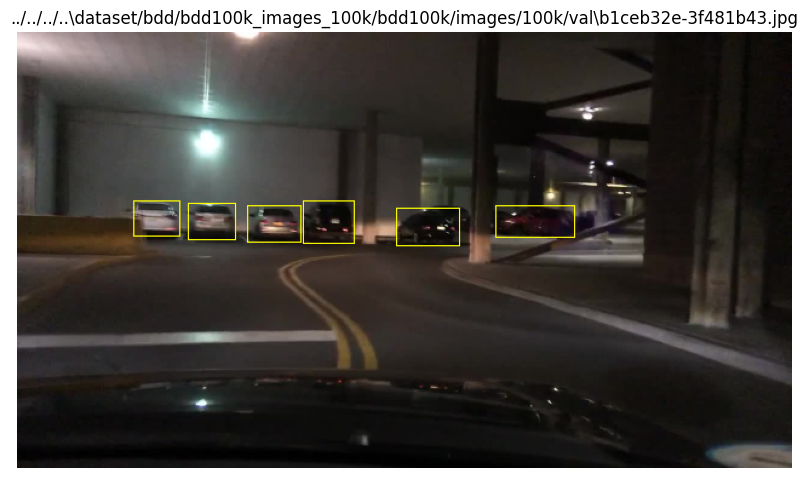

prediction scores in ascending order:
[0.7531524  0.8163492  0.9012721  0.9029239  0.9038611  0.91681707]
classification scores in ascending order:
[0.99753535 0.9993616  0.9994665  0.9995541  0.99963284 0.99964714]


In [3]:
# dataset = dataset_train
dataset = dataset_val
iter_start_offset = 0
max_iters = iter_start_offset + 10

nms_thresh = 0.35
score_threshold = torch.tensor([0.6, 0.6], dtype=torch.float32).to(device)

for iter in range(iter_start_offset, max_iters):

    img, labels = dataset.__getitem__(iter)
    img_path = labels['img_path']
    img = img.unsqueeze(0).to(device)
    bboxes = [labels['bbox'].to(device)]
    clslabels = [labels['obj_class_label'].to(device)]

    pred = inference(
        detector, img, grid_coord, 
        deltas_mean, deltas_std,
        score_threshold, nms_thresh)
    
    pred_score = pred['pred_score'].cpu().numpy()
    pred_class = pred['pred_class'].cpu().numpy()
    pred_box = pred['pred_box'].cpu().numpy()
    cls_prob = pred['cls_prob'].cpu().numpy()

    vizualize_bbox_resized(img_path, pred_box, dataset_param.IMG_RESIZED_W, dataset_param.IMG_RESIZED_H, figsize=(10,8))
    print('prediction scores in ascending order:')
    print(np.sort(pred_score))
    print('classification scores in ascending order:')
    print(np.sort(cls_prob))
    print('=' * 100)